<a href="https://colab.research.google.com/github/AnnetVasileva/machineLearning/blob/main/Practical%202/Model_LR_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, plot_roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_score = sklearn.metrics.roc_auc_score(labels, predictions)
  line_name =  name+ ', AUC: ' + str(round(auc_score,4))
  plt.plot(100*fp, 100*tp, label= line_name,
           linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def print_score(labels, pred):
  accuracy  = accuracy_score(labels,pred)
  precision = precision_score(labels, pred)
  recall = recall_score(labels,pred)
  print('Accuracy : {}'.format(accuracy),
        '\nPrecision {}:'.format(precision),
        '\nRecall: {}'.format(recall))

In [5]:
# read in data
path = '/content/drive/MyDrive/ML_ECO/'
pickle_file = 'data_set_big.pkl'

with open(path + pickle_file, 'rb') as f:
  train_set =pickle.load(f) 

X = train_set['X']
y = train_set['y']
X.shape

(111680, 174)

In [6]:
# split data
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y)


In [7]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()

scaler_test.fit(X_test)
scaler_train.fit(X_train)

X_train = scaler_train.transform(X_train)
X_test = scaler_test.transform(X_test)

In [35]:
#BASE
base_lr = LogisticRegression( max_iter= 1e4, warm_start = True, solver = 'saga', penalty = 'elasticnet', l1_ratio = 0.5,n_jobs = -1)

base_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=10000.0,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=True)

In [36]:
y_pred_base = base_lr.predict_proba(X_test)[:,1]
y_base_labels = 1*(y_pred_base > 0.5)
print_score(y_test, y_base_labels)

Accuracy : 0.9470809455587392 
Precision 0.0: 
Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
confusion_matrix(y_test, y_base_labels)

array([[21154,     0],
       [ 1182,     0]])

In [8]:
# UNDERSAMPLING MODEL
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
under_lr_mod = LogisticRegression( max_iter= 1e4, warm_start = True, solver = 'saga', n_jobs = -1) # penalty = 'elasticnet', l1_ratio = 0.3,
grid_under={"C":np.logspace(-2,2,4), "penalty":["l1", "l2"],
      'class_weight' : ['balanced', None]}
under_lr = RandomizedSearchCV(estimator = under_lr_mod, param_distributions = grid_under, n_iter = 5, cv = 3, verbose=10, random_state=42, n_jobs = -1)

under_lr.fit(X_under, y_under)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=10000.0,
                                                multi_class='auto', n_jobs=-1,
                                                penalty='l2', random_state=None,
                                                solver='saga', tol=0.0001,
                                                verbose=0, warm_start=True),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                                        'class_weight': ['balanced', None],
                                        'penalty': ['l1', 'l2']},
                   pre_d

In [23]:
under_lr.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000.0, multi_class='auto', n_jobs=-1,
                   penalty='l1', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=True)

In [26]:
y_pred_under = under_lr.best_estimator_.predict_proba(X_test)[:,1]
y_under_labels = 1*(y_pred_under > 0.5)

In [27]:
print_score(y_test, y_under_labels)

Accuracy : 0.5594555873925502 
Precision 0.06951073985680191: 
Recall: 0.5913705583756346


In [28]:
confusion_matrix(y_test, y_under_labels)

array([[11797,  9357],
       [  483,   699]])

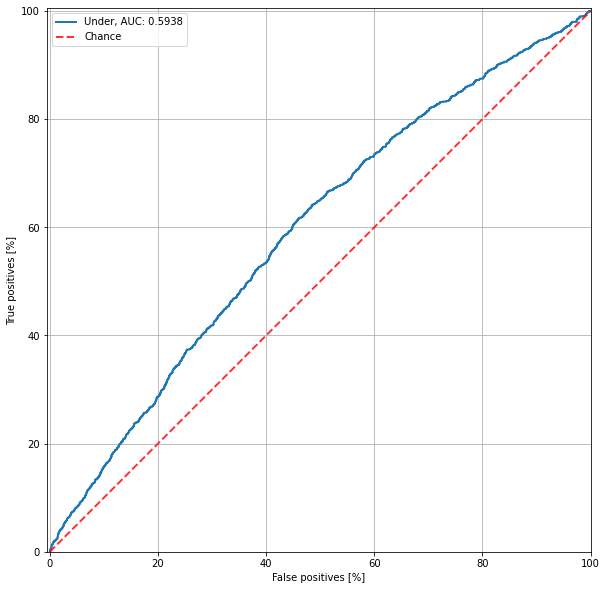

In [29]:
plot_roc('Under', y_test, y_pred_under)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()

In [30]:
#OVERSAMPLING
oversample = RandomOverSampler(0.3)
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
over_lr = LogisticRegression( max_iter= 1e4, warm_start = True, solver = 'saga', penalty = 'elasticnet', l1_ratio = 0.5,n_jobs = -1) # penalty = 'elasticnet', l1_ratio = 0.3,

over_lr.fit(X_over, y_over)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=10000.0,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=True)

In [32]:
y_pred_over = over_lr.predict_proba(X_test)[:,1]
y_over_labels = 1*(y_pred_over > 0.5)
print_score(y_test, y_over_labels)

Accuracy : 0.5762893982808023 
Precision 0.06864583333333334: 
Recall: 0.5575296108291032


In [33]:
confusion_matrix(y_test, y_over_labels)

array([[12213,  8941],
       [  523,   659]])

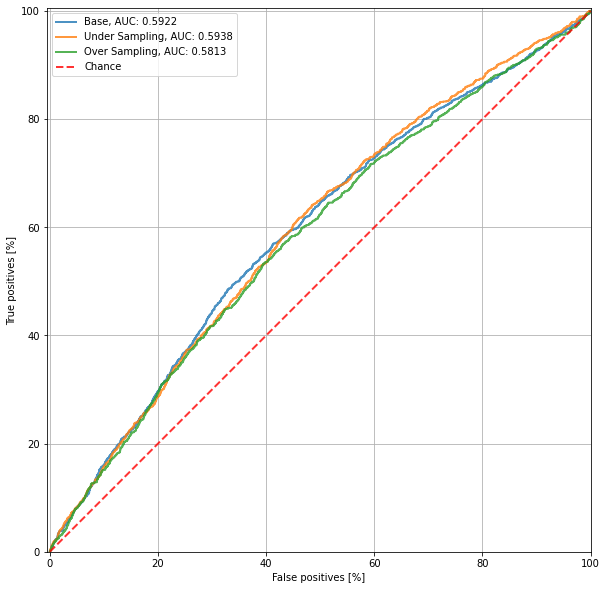

In [38]:
plot_roc('Base', y_test, y_pred_base, alpha = 0.8)
plot_roc('Under Sampling', y_test, y_pred_under, alpha = 0.8)
plot_roc('Over Sampling', y_test, y_pred_over, alpha  = 0.8)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()